<a href="https://colab.research.google.com/github/UmeshGayashan/PNEUMONIA-DETECTION-SYSTEM/blob/main/PNEUMONIA_DETECTION_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
drive_data_path = '/content/drive/MyDrive/colab_pneumonia_data'
os.makedirs(drive_data_path, exist_ok=True)

In [7]:
# Move kaggle.json credentials if needed
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset to local Colab storage
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

# Unzip into Google Drive
!unzip /content/chest-xray-pneumonia.zip -d "$drive_data_path"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /c

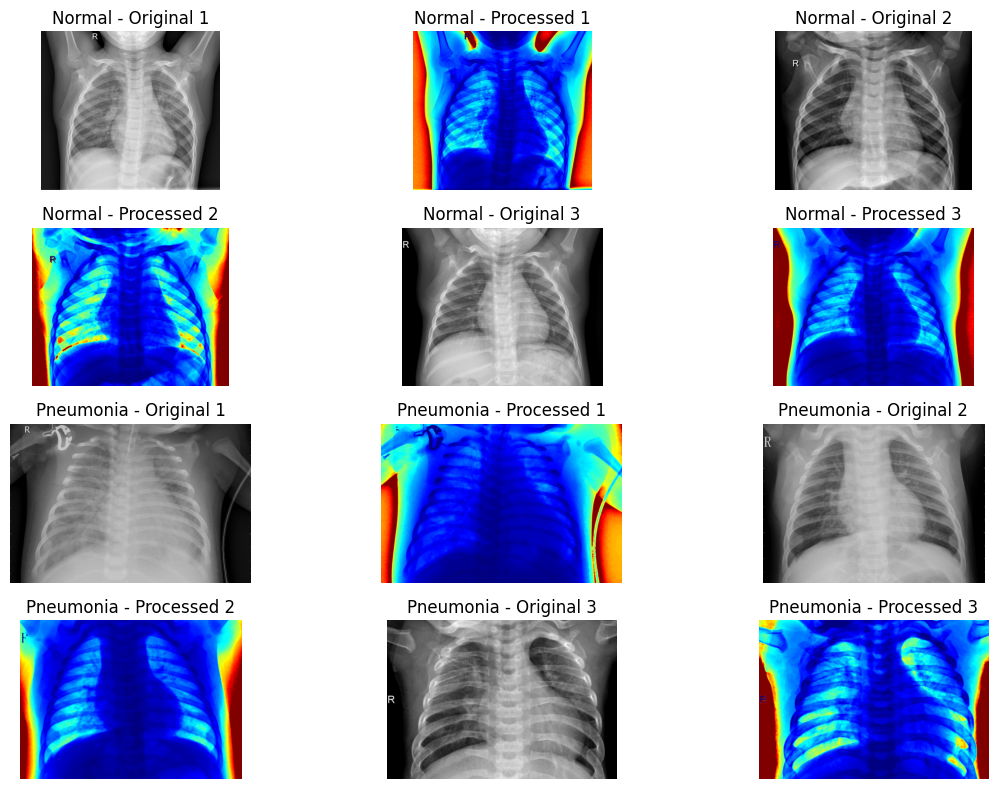

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Image Processing Functions

# Spatial domain transforms
def log_transform(img):
    c = 255 / np.log1p(np.max(img))
    return (c * np.log1p(img)).astype(np.uint8)

def gamma_transform(img, gamma=2.0):
    norm_img = img / 255.0
    return (255 * norm_img ** gamma).astype(np.uint8)

def contrast_stretch(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = np.clip((img - p2) * 255 / (p98 - p2), 0, 255)
    return img_rescale.astype(np.uint8)

def median_filter(img):
    return cv2.medianBlur(img, 5)

# Morphological operations
def morph_open(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

def morph_close(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# Color processing (pseudo-color)
def pseudo_color(img):
    return cv2.applyColorMap(img, cv2.COLORMAP_JET)

# Full preprocessing pipeline
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_log = log_transform(img)
    img_gamma = gamma_transform(img_log)
    img_contrast = contrast_stretch(img_gamma)
    img_median = median_filter(img_contrast)
    img_open = morph_open(img_median)
    img_close = morph_close(img_open)
    img_color = pseudo_color(img_close)
    return img, img_color  # Return both original and processed

# Assume drive_data_path is set and drive is mounted
normal_folder = f"{drive_data_path}/chest_xray/train/NORMAL"
pneumonia_folder = f"{drive_data_path}/chest_xray/train/PNEUMONIA"

normal_images = glob(normal_folder + "/*.jpeg")[:3]
pneumonia_images = glob(pneumonia_folder + "/*.jpeg")[:3]

plt.figure(figsize=(12, 8))

for i, img_path in enumerate(normal_images):
    base_img, processed_img = preprocess_image(img_path)
    plt.subplot(4, 3, i*2 + 1)
    plt.imshow(base_img, cmap='gray')
    plt.title(f"Normal - Original {i+1}")
    plt.axis('off')

    plt.subplot(4, 3, i*2 + 2)
    plt.imshow(processed_img)
    plt.title(f"Normal - Processed {i+1}")
    plt.axis('off')

for i, img_path in enumerate(pneumonia_images):
    base_img, processed_img = preprocess_image(img_path)
    plt.subplot(4, 3, 6 + i*2 + 1)
    plt.imshow(base_img, cmap='gray')
    plt.title(f"Pneumonia - Original {i+1}")
    plt.axis('off')

    plt.subplot(4, 3, 6 + i*2 + 2)
    plt.imshow(processed_img)
    plt.title(f"Pneumonia - Processed {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()